In [37]:
import os
import glob
import pandas as pd

# Load & Clean Data

## Import data

L'idée est de faire un script global permettant de lire, concatener et créer un seul DataFrame pour chaque jeu de données récoltées.

Chaque fichier XLSX contient plusieurs lignes explicatives au début, alors nous les retirons lors de la lecture des fichier. Les fichier excel ont aussi une feuille par région

Nous analysons d'abord la srtucture des fichiers xlsl pour pouvoir ensuite les organiser en dataframe

In [60]:
path = os.path.join("..", "..", "data", "all", "2018-3-5", "irecomicroent2018_1_perennite_xlsx")

files = files = [f for f in os.listdir(path) if f.endswith((".xls", ".xlsx"))]


df_list = []

for f in files:
    file_path = os.path.join(path, f)
    xls = pd.ExcelFile(file_path)
    
    #define the shape of the DF
    for sheet in xls.sheet_names:

        #remove useless lignes
        data = pd.read_excel(xls, sheet_name=sheet, skiprows=5)
        data = data.iloc[:-4]

        #renames columns
        data = data.rename(columns={
            data.columns[0]: "gender",
            data.columns[1]: "categories",
            data.columns[2]: "years"
        })

        data[["gender", "categories", "years"]] = data[["gender", "categories", "years"]].ffill()

        data["file_name"] = f
        data["area"] = sheet
        df_list.append(data)

df = pd.concat(df_list, ignore_index=True)

In [61]:
df

,gender,categories,years,Taux de pérennité (%),Borne inférieure du taux de\npérennité,Borne supérieure du taux de\npérennité,Nature des bornes,file_name,area
0,Sexe,Tranche d’âge du créateur en 2018,Nombre d’années depuis la création,NaN,NaN,NaN,NaN,r_peren_01.xlsx,FR
1,Ensemble,Ensemble,1 an,77.3,76.6,78.0,1.0,r_peren_01.xlsx,FR
2,Ensemble,Ensemble,2 ans,59.6,58.8,60.4,1.0,r_peren_01.xlsx,FR
3,Ensemble,Ensemble,3 ans,46.5,45.8,47.2,1.0,r_peren_01.xlsx,FR
4,Ensemble,Moins de 30 ans,1 an,67.1,65.5,68.7,1.0,r_peren_01.xlsx,FR
...,...,...,...,...,...,...,...,...,...
19093,Femme,Indemnités de chômage,3 ans,55.6,49.0,62.2,1.0,r_peren_23.xlsx,94
19094,Femme,Prestations autres que les\nprestations chômage,1 an,84.1,76.7,91.5,1.0,r_peren_23.xlsx,94
19095,Femme,Prestations autres que les\nprestations chômage,2 ans,67.0,58.5,75.5,1.0,r_peren_23.xlsx,94
19096,Femme,Prestations autres que les\nprestations chômage,3 ans,67.0,58.5,75.5,1.0,r_peren_23.xlsx,94


In [80]:
df.replace({'so': 0, 'NaN': 0, 'ns': 0, 's': 0}, inplace=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_8616\178104140.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'so': 0, 'NaN': 0, 'ns': 0, 's': 0}, inplace=True)


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19098 entries, 0 to 19097
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   gender                                 19098 non-null  object
 1   categories                             19098 non-null  object
 2   years                                  19098 non-null  object
 3   Taux de pérennité (%)                  18306 non-null  object
 4   Borne inférieure du taux de
pérennité  18306 non-null  object
 5   Borne supérieure du taux de
pérennité  18306 non-null  object
 6   Nature des bornes                      18306 non-null  object
 7   file_name                              19098 non-null  object
 8   area                                   19098 non-null  object
dtypes: object(9)
memory usage: 1.3+ MB


## Visualisation rapide

réaliser une premère visualisation pour voir l'état des données et voir s'il y a des modifications à apporter dans le DF

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

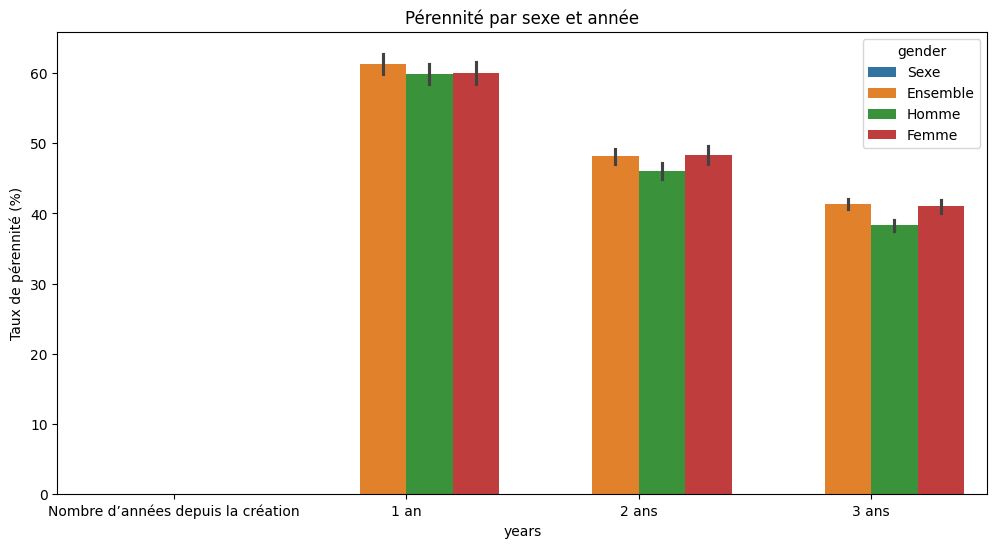

In [81]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="years", y="Taux de pérennité (%)", hue="gender"
)
plt.title("Pérennité par sexe et année")
plt.show()